## The approach

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from tqdm import tqdm_notebook
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

## Instacart dataset 

### Quick EDA on the consumers' baskets 

In [2]:
#Loading the information on orders
orders= pd.read_csv ('C:/Users/serge/desktop/instacart-market-basket-analysis/order_products__prior.csv', sep=',')
orders_train= pd.read_csv ('C:/Users/serge/desktop/instacart-market-basket-analysis/orders.csv', sep=',')

In [3]:
orders.head()

order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0

In [4]:
orders_train.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [5]:
#Keeping only neccessary columns for our analysis (orders_id, user_id, order_number )
orders_train.drop(['eval_set', 'order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis=1, inplace=True)
orders=orders.merge(orders_train, on='order_id', how='left')
orders.drop(['add_to_cart_order', 'reordered'], axis=1, inplace=True)
orders.head()

order_id  product_id  user_id  order_number
0         2       33120   202279             3
1         2       28985   202279             3
2         2        9327   202279             3
3         2       45918   202279             3
4         2       30035   202279             3

In [6]:
#Since there is 32 Million of rows we have to filter the dataset for more faster computations 
orders.shape

(32434489, 4)

0.25     5.0
0.75    24.0
Name: order_number, dtype: float64

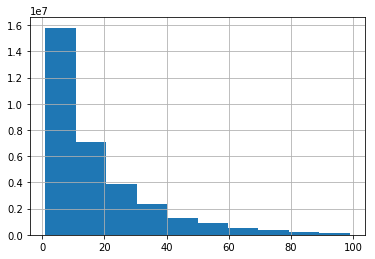

In [7]:
#There is minimum one & max 99 orders per user
orders.order_number.hist()
orders.order_number.quantile([0.25,0.75])

In [8]:
# Since we will build recommender based on the baskets (will not count previous history), let's fetch only last 1 order for each user

# Reverse the order number for each user 
orders['order_num_back'] = orders.groupby(by=['user_id'])['order_number'].transform(max) - orders.order_number + 1

# Filtering only the last 1 order
orders_last = orders.loc[orders.order_num_back <= 1]

del orders_train, orders

In [9]:
#Checking the cutted dataset
orders_last.head()

order_id  product_id  user_id  order_number  order_num_back
219        25        9755    59897            19               1
220        25       31487    59897            19               1
221        25       37510    59897            19               1
222        25       14576    59897            19               1
223        25       22105    59897            19               1

In [10]:
orders_last.shape

(2139788, 5)

In [11]:
# Creating dataset containg all baskets with last order
baskets = orders_last.groupby(['order_id'])['product_id'].progress_apply(list)

100%|██████████| 206209/206209 [00:18<00:00, 11312.80it/s]


In [12]:
df_baskets = baskets.to_frame()
df_baskets.head()

product_id
order_id                                                   
25        [9755, 31487, 37510, 14576, 22105, 1934, 6383,...
40                             [10070, 42450, 33198, 34866]
43         [20915, 21949, 8817, 37867, 12850, 21553, 34005]
51        [30274, 3594, 14994, 45433, 44514, 32624, 604,...
83        [13176, 1087, 35503, 4945, 40587, 11574, 37935...

In [13]:
df_baskets['length']=df_baskets['product_id'].map(len)
df_baskets.head()

product_id  length
order_id                                                           
25        [9755, 31487, 37510, 14576, 22105, 1934, 6383,...      14
40                             [10070, 42450, 33198, 34866]       4
43         [20915, 21949, 8817, 37867, 12850, 21553, 34005]       7
51        [30274, 3594, 14994, 45433, 44514, 32624, 604,...       9
83        [13176, 1087, 35503, 4945, 40587, 11574, 37935...      14

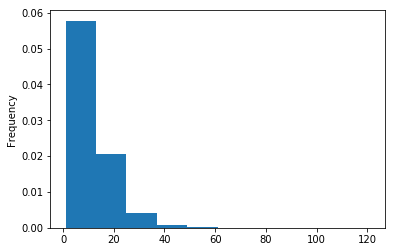

In [14]:
#Checking the average size of the basket
df_baskets.length.plot(kind='hist', density=True)

In [15]:
#Checking the average size of the basket
df_baskets.length.mean()

10.376792477534929

In [16]:
#Checking the quantiles
df_baskets.length.quantile([0.25,0.75])

0.25     5.0
0.75    14.0
Name: length, dtype: float64

75% of baskets contain up to 14 products (including the non-relevant categories)

### Removing information about non-relevant products from the baskets

In order to obtain more robust information about the size of products basket (inlcuding only products for cooking), we need to exclude non-relevant catgories.
For that pruposes we will use the information from departments

In [17]:
#loading the datasets with information of product names and thier hierarchy
products= pd.read_csv ('C:/Users/serge/desktop/instacart-market-basket-analysis/products.csv', sep=',')
aisles= pd.read_csv ('C:/Users/serge/desktop/instacart-market-basket-analysis/aisles.csv', sep=',')
departments= pd.read_csv ('C:/Users/serge/desktop/instacart-market-basket-analysis/departments.csv', sep=',')

In [18]:
products.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13

In [19]:
len(products)

49688

In [20]:
# Adding product and aisle information
products = pd.merge(products, departments, on="department_id", how='outer')
products = pd.merge(products, aisles, on="aisle_id", how='outer')
products.head()

product_id                                    product_name  aisle_id  \
0           1                      Chocolate Sandwich Cookies        61   
1          78               Nutter Butter Cookie Bites Go-Pak        61   
2         102                           Danish Butter Cookies        61   
3         172  Gluten Free All Natural Chocolate Chip Cookies        61   
4         285                    Mini Nilla Wafers Munch Pack        61   

   department_id department          aisle  
0             19     snacks  cookies cakes  
1             19     snacks  cookies cakes  
2             19     snacks  cookies cakes  
3             19     snacks  cookies cakes  
4             19     snacks  cookies cakes

In [21]:
products.department.value_counts()

personal care      6563
snacks             6264
pantry             5371
beverages          4365
frozen             4007
dairy eggs         3449
household          3085
canned goods       2092
dry goods pasta    1858
produce            1684
bakery             1516
deli               1322
missing            1258
international      1139
breakfast          1115
babies             1081
alcohol            1054
pets                972
meat seafood        907
other               548
bulk                 38
Name: department, dtype: int64

In [22]:
#We will definitely not count  the following irrelevant products in the baskets
dep_to_drop=['personal care', 'household', 'babies', 'pets']

In [23]:
for i in dep_to_drop:
    products=products[products.department!=i]

In [24]:
products.head()

product_id                                    product_name  aisle_id  \
0           1                      Chocolate Sandwich Cookies        61   
1          78               Nutter Butter Cookie Bites Go-Pak        61   
2         102                           Danish Butter Cookies        61   
3         172  Gluten Free All Natural Chocolate Chip Cookies        61   
4         285                    Mini Nilla Wafers Munch Pack        61   

   department_id department          aisle  
0             19     snacks  cookies cakes  
1             19     snacks  cookies cakes  
2             19     snacks  cookies cakes  
3             19     snacks  cookies cakes  
4             19     snacks  cookies cakes

In [25]:
#In the overall there is around 77% of products (37987 out of 49668 ) we should really count in the basket for recipes 
pr_ident=list(products.product_id)
len (pr_ident)

37987

In [26]:
df_baskets_check=df_baskets
df_baskets_check.shape

(206209, 2)

In [27]:
#But we will check the it more precisely by removing the irrelevant categories from the basket.
#It could take a while to count (3-4 mins)
df_baskets_check['new']=df_baskets_check.product_id.apply(lambda x: [i for i in x if i in pr_ident])
df_baskets_check.head()

product_id  length  \
order_id                                                              
25        [9755, 31487, 37510, 14576, 22105, 1934, 6383,...      14   
40                             [10070, 42450, 33198, 34866]       4   
43         [20915, 21949, 8817, 37867, 12850, 21553, 34005]       7   
51        [30274, 3594, 14994, 45433, 44514, 32624, 604,...       9   
83        [13176, 1087, 35503, 4945, 40587, 11574, 37935...      14   

                                                        new  
order_id                                                     
25        [9755, 31487, 37510, 14576, 22105, 1934, 6383,...  
40                             [10070, 42450, 33198, 34866]  
43                      [20915, 21949, 37867, 21553, 34005]  
51        [30274, 3594, 14994, 45433, 44514, 32624, 2119...  
83        [13176, 1087, 35503, 4945, 40587, 11574, 37935...

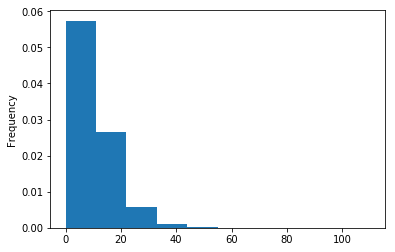

In [28]:
df_baskets_check['length_new']=df_baskets_check['new'].map(len)

#Now we can re-check the basket size containg only potential products for recipes
df_baskets_check.length_new.plot(kind='hist', density=True)

In [29]:
#Excluding orders with zero basket after removing the specific categories
df_baskets_check=df_baskets_check[df_baskets_check.length_new>0]

In [30]:
#Checking the average size of the basket
df_baskets_check.length_new.mean()

9.903972877237162

In [31]:
#Checking the quantiles
df_baskets_check.length_new.quantile([0.25,0.75])

0.25     4.0
0.75    13.0
Name: length_new, dtype: float64

In [32]:
df_baskets=df_baskets_check.copy()
del df_baskets_check

We can see that 75% of baskets now contain up to 13 products which could potentially match with recipes (on average it is around 10)

## Pre-processing products names for Word2Vec model

Since we will be using word2Vec model for obtaining similarity between recipes and products in baskets we have to pre-process names in both dataset

First of all, let's observe how the product names are presented in each dataset

### Instacart products dataset

In [33]:
#We already excluded irrelavant categories from the basket
products.head()

product_id                                    product_name  aisle_id  \
0           1                      Chocolate Sandwich Cookies        61   
1          78               Nutter Butter Cookie Bites Go-Pak        61   
2         102                           Danish Butter Cookies        61   
3         172  Gluten Free All Natural Chocolate Chip Cookies        61   
4         285                    Mini Nilla Wafers Munch Pack        61   

   department_id department          aisle  
0             19     snacks  cookies cakes  
1             19     snacks  cookies cakes  
2             19     snacks  cookies cakes  
3             19     snacks  cookies cakes  
4             19     snacks  cookies cakes

In [34]:
#We can see that the products list is presented by one product from the basket
products.product_name.head(10)

0                           Chocolate Sandwich Cookies
1                    Nutter Butter Cookie Bites Go-Pak
2                                Danish Butter Cookies
3       Gluten Free All Natural Chocolate Chip Cookies
4                         Mini Nilla Wafers Munch Pack
5                             Organic Lemon Gingersnap
6                            Chips Ahoy! Chewy Cookies
7    Cookie Chips Crunchy Dark Chocolate Chocolate ...
8                               Golden Cupcakes 8 Pack
9                    Crunch Vanilla Sugar Mini Cookies
Name: product_name, dtype: object

In [35]:
#Now we have 37987 products
len(products)

37987

In [36]:
#We should keep only id and product name
products.drop(['aisle_id', 'department_id', 'aisle', 'department'], axis=1, inplace=True)
products.head()

product_id                                    product_name
0           1                      Chocolate Sandwich Cookies
1          78               Nutter Butter Cookie Bites Go-Pak
2         102                           Danish Butter Cookies
3         172  Gluten Free All Natural Chocolate Chip Cookies
4         285                    Mini Nilla Wafers Munch Pack

In [37]:
# Later on for the assessments of recommendation we should replace the product_id with products names, so we will build a dictionary now
instacart_names=products[['product_id', 'product_name']]
instacart_names.sort_values('product_id').head(15)

product_id                                       product_name
0               1                         Chocolate Sandwich Cookies
6264            2                                   All-Seasons Salt
11635           3               Robust Golden Unsweetened Oolong Tea
16000           4  Smart Ones Classic Favorites Mini Rigatoni Wit...
7061            5                          Green Chile Anytime Sauce
12529           7                     Pure Coconut Water With Orange
16880           8                  Cut Russet Potatoes Steam N' Mash
26570           9                  Light Strawberry Blueberry Yogurt
13321          10     Sparkling Orange Juice & Prickly Pear Beverage
13665          11                                  Peach Mango Juice
17241          12                         Chocolate Fudge Layer Cake
874            16                      Mint Chocolate Flavored Syrup
34185          17                                  Rendered Duck Fat
17353          18                Pizza for One Suprema  Frozen Pizza
35092          19   Gluten Free Quinoa Three Cheese & Mushroom Blend

In [38]:
#Creating dictionary
dic_instacart = dict((key, value) for (key, value) in zip(instacart_names.product_name, instacart_names.product_id))
dic_instacart

{'Chocolate Sandwich Cookies': 1,
 'Nutter Butter Cookie Bites Go-Pak': 78,
 'Danish Butter Cookies': 102,
 'Gluten Free All Natural Chocolate Chip Cookies': 172,
 'Mini Nilla Wafers Munch Pack': 285,
 'Organic Lemon Gingersnap': 331,
 'Chips Ahoy! Chewy Cookies': 449,
 'Cookie Chips Crunchy Dark Chocolate Chocolate Chip Cookies': 559,
 'Golden Cupcakes 8 Pack': 569,
 'Crunch Vanilla Sugar Mini Cookies': 574,
 'Vanilla Sugar Cookies': 576,
 'Fudge Brownies with English Walnuts': 622,
 'Low Fat Honey Graham Crackers': 627,
 'Little Bites Snickerdoodle Muffins': 635,
 'Keebler Sandies Cashew 12.8 Oz': 658,
 "Cinnamon Pop'ettes": 733,
 "Chocolate Reese's Peanut Butter Cup Creme Oreo": 796,
 'Pure Butter Shortbread Scottie Dogs': 1058,
 'Organic Family Recipe Chocolate Chip Cookies': 1129,
 'Pecan Sandies Simply Sandies': 1209,
 'Mini Strawberry Donuts': 1256,
 'Spring Vanilla Cup Cake': 1419,
 'Soft Frosty Lemon Cookies': 1473,
 'Cookie Bites Chocolate Chip Cookies': 1547,
 'Disney Frozen

In [39]:
len(dic_instacart)

37987

In [40]:
products.head()

product_id                                    product_name
0           1                      Chocolate Sandwich Cookies
1          78               Nutter Butter Cookie Bites Go-Pak
2         102                           Danish Butter Cookies
3         172  Gluten Free All Natural Chocolate Chip Cookies
4         285                    Mini Nilla Wafers Munch Pack

### Recipes dataset 

In [41]:
train= pd.read_json ('C:/Users/serge/Desktop/recipe-ingredients-dataset/train.json')
test= pd.read_json ('C:/Users/serge/Desktop/recipe-ingredients-dataset/test.json')

In [42]:
train.head()

cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [44]:
test.head()

id                                        ingredients
0  18009  [baking powder, eggs, all-purpose flour, raisi...
1  28583  [sugar, egg yolks, corn starch, cream of tarta...
2  41580  [sausage links, fennel bulb, fronds, olive oil...
3  29752  [meat cuts, file powder, smoked sausage, okra,...
4  35687  [ground black pepper, salt, sausage casings, l...

In [45]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9944 entries, 0 to 9943
Data columns (total 2 columns):
id             9944 non-null int64
ingredients    9944 non-null object
dtypes: int64(1), object(1)
memory usage: 155.5+ KB


In [46]:
#First of all, we decided to increase the number of instances for training our model we will combine train and test datasets, even though we drop the cuisine variable
recipes=train.append(test)

In [47]:
#We can drop the cusine
recipes.drop(['cuisine'], axis=1, inplace=True)

In [48]:
#Now we should check the recipes length
recipes['length']=recipes['ingredients'].map(len)
recipes.head()

id                                        ingredients  length
0  10259  [romaine lettuce, black olives, grape tomatoes...       9
1  25693  [plain flour, ground pepper, salt, tomatoes, g...      11
2  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...      12
3  22213                [water, vegetable oil, wheat, salt]       4
4  13162  [black pepper, shallots, cornflour, cayenne pe...      20

At this stage we can also check that how much the recipes' size fits the basket length

In [49]:
#The average length of the recipe is larger than length of average basket, so we have to filter out 13+ ingredients recipes
recipes.length.describe()

count    49718.000000
mean        10.774166
std          4.436613
min          1.000000
25%          8.000000
50%         10.000000
75%         13.000000
max         65.000000
Name: length, dtype: float64

In [50]:
#Filtering according to the baskets length
recipes=recipes[recipes.length<=13]

In [51]:
recipes.length.describe()

count    37635.000000
mean         8.825800
std          2.692126
min          1.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         13.000000
Name: length, dtype: float64

In [52]:
#Creating vocabulary based on products' ingredients
len(recipes)

37635

In [53]:
#Reseting index
recipes=recipes.reset_index()
recipes.drop('index', axis=1, inplace=True)

In [54]:
recipes.head()

id                                        ingredients  length
0  10259  [romaine lettuce, black olives, grape tomatoes...       9
1  25693  [plain flour, ground pepper, salt, tomatoes, g...      11
2  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...      12
3  22213                [water, vegetable oil, wheat, salt]       4
4   6602  [plain flour, sugar, butter, eggs, fresh ginge...      12

In [55]:
len(recipes)

37635

In [56]:
#Appending all the ingredients to one list (list of lists)
row_list=[]

for index, row in recipes.iterrows():
    my_list=[row.ingredients]
    row_list.append(my_list)
    
len(row_list)

37635

In [57]:
#Making the final list of products
flat_list = [item for sublist in row_list for item in sublist]
final_list= [item for sublist in flat_list for item in sublist]
final_list.sort()
final_list

['(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(    oz.) tomato sauce',
 '(   oz.) tomato paste',
 '(   oz.) tomato paste',
 '(   oz.) tomato paste',
 '(10 oz.) frozen chopped spinach',
 '(10 oz.) frozen chopped spinach',
 '(10 oz.) frozen chopped spinach',
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry',
 '(14 oz.) sweetened condensed milk',
 '(14 oz.) sweetened condensed milk',
 '(14.5 oz.) diced tomatoes',
 '(15 oz.) refried beans',
 '(15 oz.) refried beans',
 '1% low-fat buttermilk',
 '1% low-fat buttermilk',
 '1% low-fat buttermilk',
 '1% low-fat buttermilk',
 '1% low-fat buttermilk',
 '1% low-fat chocolate milk',
 '1% low-fat chocolate milk',
 '1% low-fat cottage cheese',
 '1% low-fat cottage cheese',
 '1% low-fat cottage cheese',
 '1% low-fat cottage cheese',
 '1% low-fat cottage cheese',
 '1% low-f

In [58]:
len(final_list)

332159

In [59]:
# Removing duplicated ingredients in the list
final_list=list(set(final_list))
len(final_list)

6404

In [60]:
#Checking the list of ingredients. Looks fine
final_list

['Oscar Mayer Bacon',
 'cream cheese',
 'braggs liquid aminos',
 'sweet gherkin',
 'store-bought pound cake',
 'sauce tomato',
 'canned chopped tomatoes',
 'boy choy',
 'distilled malt vinegar',
 'day old bread',
 'tamari soy sauce',
 'whole wheat fusilli',
 'yellow split peas',
 'coconut water',
 'frozen mashed potatoes',
 'drumstick',
 'bertolli vineyard premium collect marinara with burgundi wine sauc',
 'whole cloves',
 'hot sausage',
 'pizza shells',
 'sweetener',
 'shredded low-fat jarlsberg cheese',
 'unbleached flour',
 'hake fillets',
 'wide rice noodles',
 'glass noodles',
 'beef brisket',
 'rotisserie chicken',
 'pitted green olives',
 'crispy bacon',
 'rolls',
 'garbanzo beans',
 'pekin duck breast halves',
 'Melba toast',
 'cubed ham',
 'pecan halves',
 'beluga lentil',
 'tahini',
 'garlic sauce',
 'dashi powder',
 'sliced fresh fruit',
 'russet',
 'littleneck clams',
 'corn salsa',
 'smoked cheddar cheese',
 'reduced-sodium tamari sauce',
 'crescent dinner rolls',
 'rock 

In [61]:
from collections import Counter

counts = Counter()

for ingr in final_list:
    counts.update(ingr.strip(',') for word in ingr.split())

# Printing the ingredients occurances:
counts.most_common(50)

[('KRAFT Mexican Style Shredded Four Cheese with a TOUCH OF PHILADELPHIA', 11),
 ("i can't believ it' not butter! made with olive oil spread", 11),
 ('KRAFT Shredded Pepper Jack Cheese with a TOUCH OF PHILADELPHIA', 10),
 ('2 1/2 to 3 lb. chicken, cut into serving pieces', 10),
 ('bertolli vineyard premium collect marinara with burgundi wine sauc', 9),
 ('Best Foods Mayonnaise Dressing with Extra Virgin Olive Oil', 9),
 ("I Can't Believe It's Not Butter!В® All Purpose Sticks", 9),
 ('(10 oz.) frozen chopped spinach, thawed and squeezed dry', 9),
 ('condensed reduced fat reduced sodium cream of mushroom soup', 9),
 ('ragu old world style sweet tomato basil pasta sauc', 9),
 ('reduced fat reduced sodium condensed cream of chicken soup', 9),
 ('KRAFT Mexican Style 2% Milk Finely Shredded Four Cheese', 9),
 ('Hidden ValleyВ® Original Ranch SaladВ® Dressing & Seasoning Mix', 9),
 ('reduced fat reduced sodium tomato and herb pasta sauce', 9),
 ('Soy VayВ® Veri Veri TeriyakiВ® Marinade & Sauc

In [62]:
#Now we need to assign the certain number to each ingredient in the list (create a dictionary)
d = {ni: indi for indi, ni in enumerate(set(final_list))}
#numbers = [d[ni] for ni in final_list]

In [63]:
type(d)

dict

In [64]:
#Creating dataframe with ingredients of recipes
recipes_id=pd.DataFrame.from_dict(d, orient='index').reset_index()
recipes_id.columns=['products', 'id']
recipes_id.head()

products  id
0        Oscar Mayer Bacon   0
1             cream cheese   1
2     braggs liquid aminos   2
3            sweet gherkin   3
4  store-bought pound cake   4

Now we are ready to join product names from both resources for text-processing 

### Appending all product words to one dataset 

Let's check the datasets again before appending

In [198]:
products.head()

product_id                                    product_name
0           1                      Chocolate Sandwich Cookies
1          78               Nutter Butter Cookie Bites Go-Pak
2         102                           Danish Butter Cookies
3         172  Gluten Free All Natural Chocolate Chip Cookies
4         285                    Mini Nilla Wafers Munch Pack

In [199]:
recipes_id.head()

products  id
0        Oscar Mayer Bacon   0
1             cream cheese   1
2     braggs liquid aminos   2
3            sweet gherkin   3
4  store-bought pound cake   4

In [200]:
#We have to name the columns identically
df1=products.rename(columns={'product_id': 'id', 'product_name':'products'})
df2=recipes_id

In [201]:
df1.head()

id                                        products
0    1                      Chocolate Sandwich Cookies
1   78               Nutter Butter Cookie Bites Go-Pak
2  102                           Danish Butter Cookies
3  172  Gluten Free All Natural Chocolate Chip Cookies
4  285                    Mini Nilla Wafers Munch Pack

In [202]:
len(df1)

37987

In [203]:
df2.head()

products  id
0        Oscar Mayer Bacon   0
1             cream cheese   1
2     braggs liquid aminos   2
3            sweet gherkin   3
4  store-bought pound cake   4

In [204]:
len(df2)

6404

In [205]:
df_merged=df1.append(df2)
df_merged.head()

id                                        products
0    1                      Chocolate Sandwich Cookies
1   78               Nutter Butter Cookie Bites Go-Pak
2  102                           Danish Butter Cookies
3  172  Gluten Free All Natural Chocolate Chip Cookies
4  285                    Mini Nilla Wafers Munch Pack

In [206]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44391 entries, 0 to 6403
Data columns (total 2 columns):
id          44391 non-null int64
products    44391 non-null object
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


In [207]:
df=df_merged.set_index(['id']).reset_index()

In [208]:
df.tail()

id           products
44386  6399     Braeburn Apple
44387  6400        stolichnaya
44388  6401      venison roast
44389  6402         miso paste
44390  6403  Crystal Hot Sauce

In [209]:
#Creating new variable we will indexing through
df['id_new']= df.index

In [210]:
df.tail()

id           products  id_new
44386  6399     Braeburn Apple   44386
44387  6400        stolichnaya   44387
44388  6401      venison roast   44388
44389  6402         miso paste   44389
44390  6403  Crystal Hot Sauce   44390

In [211]:
df.id_new.nunique()

44391

Now we are ready for NLP-techinques

In [212]:
# Make everything lowercase
df['products_mod'] = df['products'].str.lower()

# Remove all special characters and numbers
df['products_mod'] = df['products_mod'].str.replace(r"[^a-zA-Z ]+", " ").str.strip()

df['products_mod'] = df['products_mod'].str.replace(r'[0-9/,-]+', " ").str.strip()

df['products_mod'] = df['products_mod'].str.replace(r'[\[\],\')Â¿?^*"(–\.;$%_:+<>⁄•—,%§‟––¾½¼]', " ").str.strip()

#Tokenizing the words
df['products_mod'] = df['products_mod'].str.split()

# Removing stopwords
set_of_stopwords = set(stopwords.words("english"))
df['products_mod_stopwords'] = df['products_mod'].apply(lambda x: [w for w in x if not w in set_of_stopwords])

# Removing special words (as they responsible for measurement the wieghts)
words_to_eliminate = ['mg','additional', 'accompaniments','accompaniment','about','a ','ml','oz','ounce','ounces','cups','cup','spoon','spoons','teaspoon','teaspoons','tablespoon','tablespoons','pound','pounds','lb','pinch','Pinch','inch'] 
df['products_mod_special'] = df['products_mod_stopwords'].apply(lambda x: [w for w in x if not w in words_to_eliminate])

# Normalising the words using Lemmatizer (it is the process of converting a word to its base form):
wordnet_lemmatizer = WordNetLemmatizer()
df['products_lemma'] = df['products_mod_special'].apply(lambda x:[wordnet_lemmatizer.lemmatize(w) for w in x])

df.head()

id                                        products  id_new  \
0    1                      Chocolate Sandwich Cookies       0   
1   78               Nutter Butter Cookie Bites Go-Pak       1   
2  102                           Danish Butter Cookies       2   
3  172  Gluten Free All Natural Chocolate Chip Cookies       3   
4  285                    Mini Nilla Wafers Munch Pack       4   

                                        products_mod  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, all, natural, chocolate, chip, ...   
4                 [mini, nilla, wafers, munch, pack]   

                              products_mod_stopwords  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                products_mod_special  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                    products_lemma  
0                     [chocolate, sandwich, cooky]  
1          [nutter, butter, cookie, bite, go, pak]  
2                          [danish, butter, cooky]  
3  [gluten, free, natural, chocolate, chip, cooky]  
4                [mini, nilla, wafer, munch, pack]

In [213]:
#Converting products into strings again to see the map of words
df['wordcloud'] = df['products_lemma'].apply(lambda x: ','.join([str(i) for i in x]))
df.head()

id                                        products  id_new  \
0    1                      Chocolate Sandwich Cookies       0   
1   78               Nutter Butter Cookie Bites Go-Pak       1   
2  102                           Danish Butter Cookies       2   
3  172  Gluten Free All Natural Chocolate Chip Cookies       3   
4  285                    Mini Nilla Wafers Munch Pack       4   

                                        products_mod  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, all, natural, chocolate, chip, ...   
4                 [mini, nilla, wafers, munch, pack]   

                              products_mod_stopwords  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                products_mod_special  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                    products_lemma  \
0                     [chocolate, sandwich, cooky]   
1          [nutter, butter, cookie, bite, go, pak]   
2                          [danish, butter, cooky]   
3  [gluten, free, natural, chocolate, chip, cooky]   
4                [mini, nilla, wafer, munch, pack]   

                                  wordcloud  
0                  chocolate,sandwich,cooky  
1          nutter,butter,cookie,bite,go,pak  
2                       danish,butter,cooky  
3  gluten,free,natural,chocolate,chip,cooky  
4               mini,nilla,wafer,munch,pack

Now we will map the most frequent words from our processed vocabulary

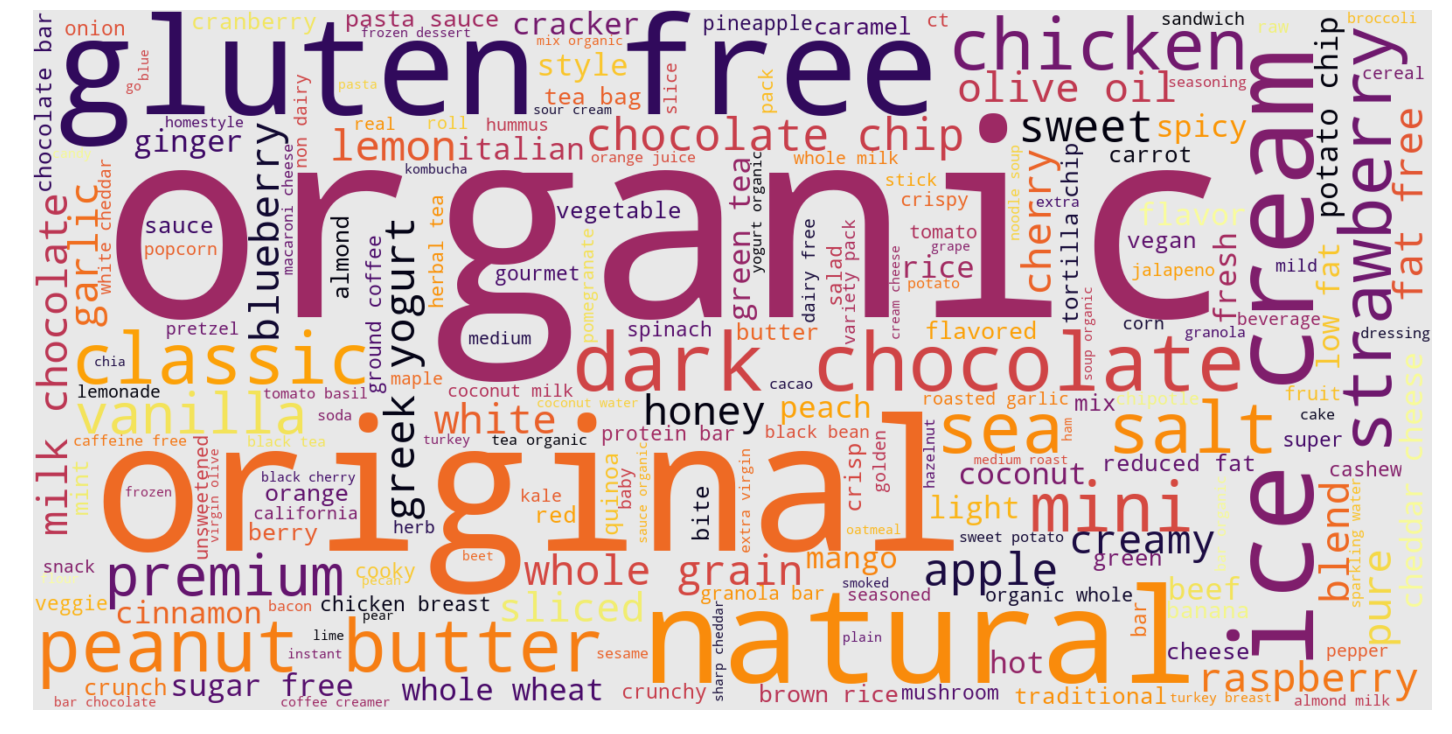

In [214]:
from wordcloud import WordCloud


#Instacart pre-processed words


text_instacart = df.iloc[0:37979].wordcloud.str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, background_color="#E8E8E8",colormap="inferno_r", min_font_size = 10).generate(text_instacart) 
%matplotlib inline
# plot the WordCloud image                        
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear') 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

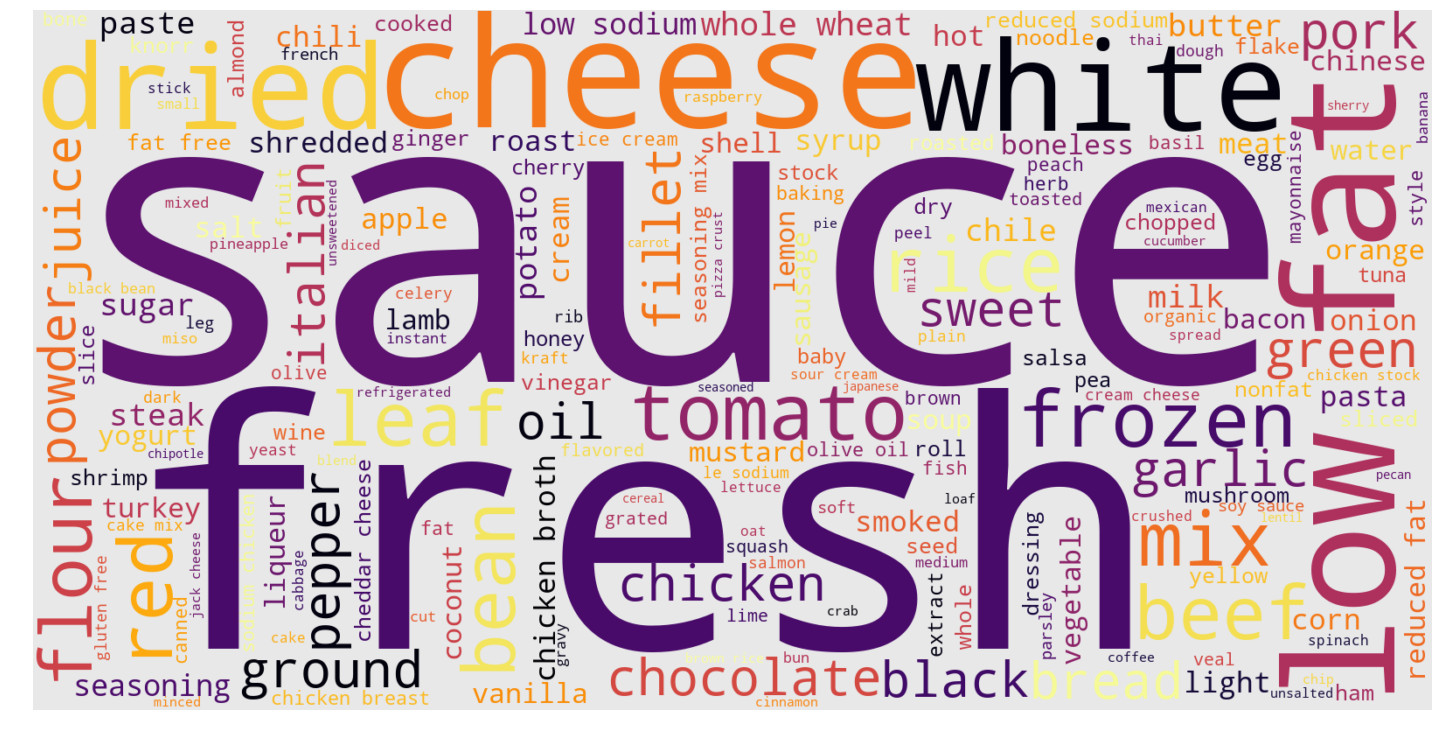

In [215]:
# Recipe pre-processed words

text_recipes = df.iloc[37979:].wordcloud.str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, background_color="#E8E8E8",colormap="inferno_r", min_font_size = 10).generate(text_recipes) 
%matplotlib inline
# plot the WordCloud image                        
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear') 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

We can see that the Instacart dict contains too many adjectives, which could be potentiall useless for recipes (i.e. organic, gluten free, original, natural).

In [217]:
extra_words_remove=['organic', 'original', 'classic', 'gluten', 'free', 'fresh', 'natural', 'premium', 'traditional']
df['products_mod_fin'] = df['products_lemma'].apply(lambda x: [w for w in x if not w in extra_words_remove])

Printing the final dictionary

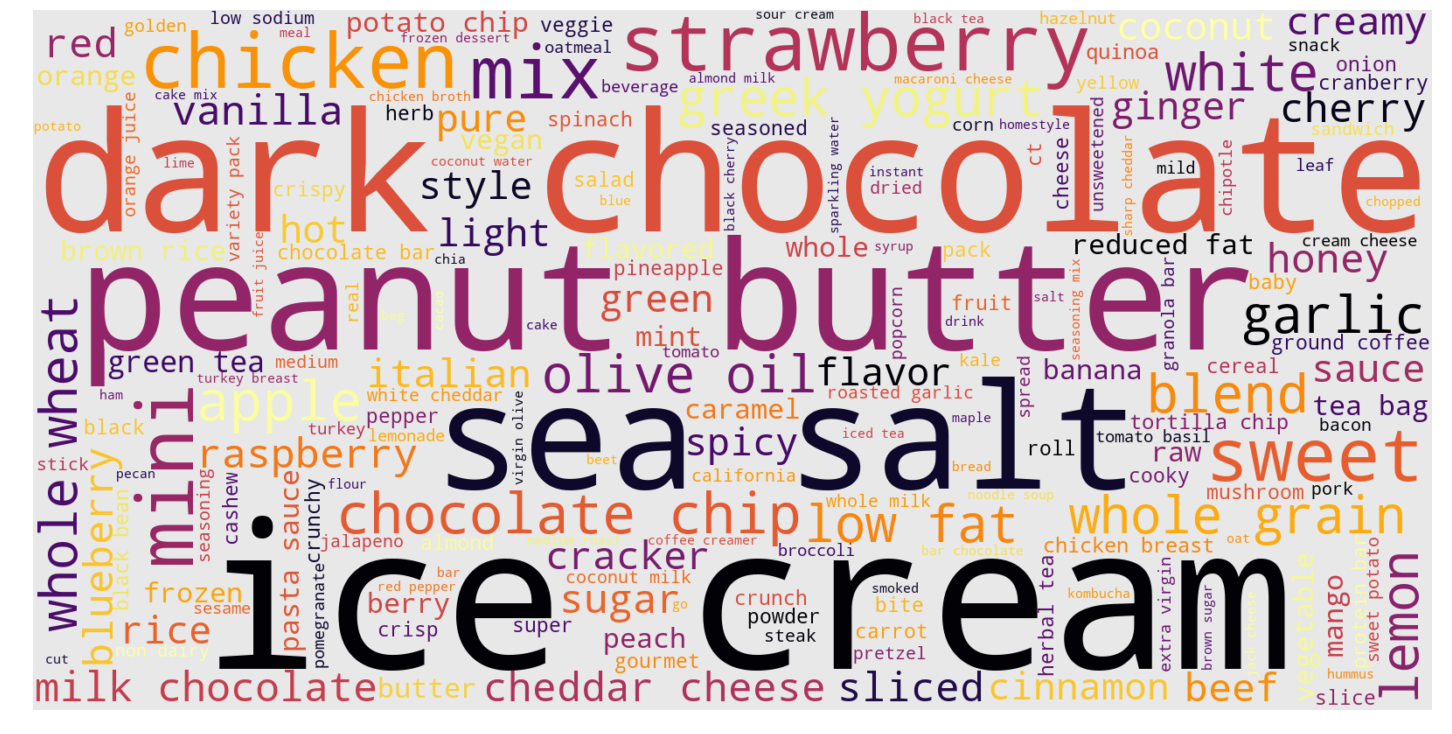

In [218]:
#Final dictionary
final_dict = df['products_mod_fin'].apply(lambda x: ','.join([str(i) for i in x]))
text = final_dict.str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, background_color="#E8E8E8",colormap="inferno_r", min_font_size = 10).generate(text) 
%matplotlib inline
# plot the WordCloud image                        
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear') 

plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [220]:
df.head(5)

id                                        products  id_new  \
0    1                      Chocolate Sandwich Cookies       0   
1   78               Nutter Butter Cookie Bites Go-Pak       1   
2  102                           Danish Butter Cookies       2   
3  172  Gluten Free All Natural Chocolate Chip Cookies       3   
4  285                    Mini Nilla Wafers Munch Pack       4   

                                        products_mod  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, all, natural, chocolate, chip, ...   
4                 [mini, nilla, wafers, munch, pack]   

                              products_mod_stopwords  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                products_mod_special  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                    products_lemma  \
0                     [chocolate, sandwich, cooky]   
1          [nutter, butter, cookie, bite, go, pak]   
2                          [danish, butter, cooky]   
3  [gluten, free, natural, chocolate, chip, cooky]   
4                [mini, nilla, wafer, munch, pack]   

                                  wordcloud  \
0                  chocolate,sandwich,cooky   
1          nutter,butter,cookie,bite,go,pak   
2                       danish,butter,cooky   
3  gluten,free,natural,chocolate,chip,cooky   
4               mini,nilla,wafer,munch,pack   

                          products_mod_fin  
0             [chocolate, sandwich, cooky]  
1  [nutter, butter, cookie, bite, go, pak]  
2                  [danish, butter, cooky]  
3                 [chocolate, chip, cooky]  
4        [mini, nilla, wafer, munch, pack]

But before moving to model creation, we have to understand which hyperparameter (window size) we have to set. For that purpose we should also count the amount of words in each product row

In [221]:
#75% of products contains 5 words 
df['length']=df['products_mod_fin'].map(len)
df['length'].describe()

count    44391.000000
mean         3.697123
std          1.680808
min          0.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         20.000000
Name: length, dtype: float64

In [427]:
df[df.length==0]

id           products  id_new     products_mod  \
15322    530                7UP   15322             [up]   
15347   3186  1893 Original Can   15347  [original, can]   
15361   4156               7-Up   15361             [up]   
18634  28921           Original   18634       [original]   
26624  43552       The Original   26624  [the, original]   
35415  18561                805   35415               []   
35465  25334               1664   35465               []   
35829  38324               2010   35829               []   
39383   1396              fresh   39383          [fresh]   
39723   1736               7 Up   39723             [up]   
40417   2430              other   40417          [other]   
41262   3275      accompaniment   41262  [accompaniment]   
42478   4491             gluten   42478         [gluten]   
42790   4803                any   42790            [any]   

      products_mod_stopwords products_mod_special products_lemma wordcloud  \
15322                     []                   []             []             
15347             [original]           [original]     [original]  original   
15361                     []                   []             []             
18634             [original]           [original]     [original]  original   
26624             [original]           [original]     [original]  original   
35415                     []                   []             []             
35465                     []                   []             []             
35829                     []                   []             []             
39383                [fresh]              [fresh]        [fresh]     fresh   
39723                     []                   []             []             
40417                     []                   []             []             
41262        [accompaniment]                   []             []             
42478               [gluten]             [gluten]       [gluten]    gluten   
42790                     []                   []             []             

      products_mod_fin  length  
15322               []       0  
15347               []       0  
15361               []       0  
18634               []       0  
26624               []       0  
35415               []       0  
35465               []       0  
35829               []       0  
39383               []       0  
39723               []       0  
40417               []       0  
41262               []       0  
42478               []       0  
42790               []       0

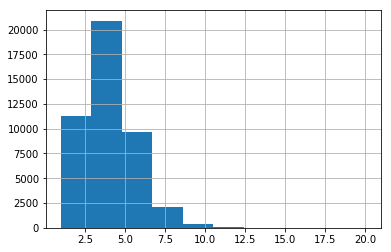

In [223]:
df_fin=df[df.length>0]
df_fin['length'].hist()

In order to make sure all most common words are used in training the model, we're going to set a large - window=5.

## Creating Word2Vec model

In [224]:
from gensim.models import Word2Vec

In [225]:
# We will set the dimensions size to 100 (as recommended by Spotify)  #setting seed for reprodusability 
w2vec_model = Word2Vec(list(df_fin['products_mod_fin']), size=100, window=5, min_count=1, workers=4, seed=444)

In [226]:
# Create  dictionaries to obtain product vectors
prod_word = dict()
for w in w2vec_model.wv.vocab:
    prod_word[w] = w2vec_model[w]

In [227]:
display(list(prod_word.items())[:2])

[('chocolate',
  array([-0.5071904 ,  0.28879154,  0.57899904,  0.44427615,  0.80671746,
         -0.08953315,  0.54462355,  0.49548182, -0.58157885,  0.20349544,
         -0.21180214, -0.10290968,  0.6969775 ,  0.28091994, -1.0720736 ,
          1.1192039 , -0.75335586,  0.381895  ,  0.43840745, -0.3413384 ,
          0.4848499 ,  0.15297914, -1.0438248 , -0.8154347 , -0.23363289,
         -0.47590202,  0.5998145 ,  0.74855006,  1.0329155 ,  0.42365676,
          0.9869944 ,  0.4129977 ,  0.2626358 ,  0.81964195, -0.54728746,
          1.2697979 , -0.25065574,  0.267531  ,  0.39009866,  0.07946507,
         -0.07026499, -0.15186727,  1.3793963 , -0.90843934, -0.18535376,
         -1.1582898 ,  0.19147524,  0.29815656, -0.79544055,  0.13214692,
         -0.21179302, -0.6454037 ,  0.04896142,  0.20289107,  0.4621    ,
         -0.17155679, -0.596839  ,  0.909234  ,  0.37372112,  0.3065625 ,
         -0.00606305,  0.14310023,  0.9556343 ,  0.23107478,  0.06109842,
         -0.38439682, -

In [228]:
# VECTOR CALCULATION FOR PRODUCTS
# Cycle through each word in the product name to generate the vector.
prods_w2v = dict()
for row, col in tqdm(df_fin.iterrows()):
    word_vector = list()
    for word in col['products_mod_fin']:
        word_vector.append(prod_word[word])

    prods_w2v[col['id_new']] = np.average(word_vector, axis=0)  

44377it [00:05, 8607.58it/s]


In [229]:
display(list(prods_w2v.items())[:2])

[(0, array([-0.4065014 ,  0.2893578 ,  0.39730456,  0.37992024,  0.8484104 ,
         -0.16219825,  0.42323837,  0.47633734, -0.5565681 ,  0.26237443,
         -0.13210969, -0.05406091,  0.49988222,  0.4241352 , -0.94370264,
          0.9021371 , -0.5536749 ,  0.33438322,  0.32054308, -0.18158905,
          0.31303754,  0.1643297 , -0.9113324 , -0.57797945, -0.07761022,
         -0.30928993,  0.40806922,  0.5124385 ,  0.7817165 ,  0.2724091 ,
          0.6429    ,  0.20245655,  0.2814034 ,  0.52017164, -0.31832352,
          0.8650401 , -0.27177164,  0.31722936,  0.22975637,  0.10736798,
         -0.07590085, -0.2079163 ,  1.0436692 , -0.81030244, -0.0610235 ,
         -1.0356272 ,  0.2723743 ,  0.07644111, -0.6229666 ,  0.02740482,
         -0.23064423, -0.53721184, -0.03496515,  0.33204234,  0.51117355,
         -0.34303594, -0.46368173,  0.73717237,  0.21500857,  0.14855368,
          0.14593974,  0.10894916,  0.7788789 ,  0.11720806,  0.14975566,
         -0.17843312, -0.44149554, 

In [230]:
# Save vector values in list form to the dataframe. 
df_fin['vectors']=prods_w2v.values()

In [231]:
df_fin.head()

id                                        products  id_new  \
0    1                      Chocolate Sandwich Cookies       0   
1   78               Nutter Butter Cookie Bites Go-Pak       1   
2  102                           Danish Butter Cookies       2   
3  172  Gluten Free All Natural Chocolate Chip Cookies       3   
4  285                    Mini Nilla Wafers Munch Pack       4   

                                        products_mod  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, all, natural, chocolate, chip, ...   
4                 [mini, nilla, wafers, munch, pack]   

                              products_mod_stopwords  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                products_mod_special  \
0                     [chocolate, sandwich, cookies]   
1           [nutter, butter, cookie, bites, go, pak]   
2                          [danish, butter, cookies]   
3  [gluten, free, natural, chocolate, chip, cookies]   
4                 [mini, nilla, wafers, munch, pack]   

                                    products_lemma  \
0                     [chocolate, sandwich, cooky]   
1          [nutter, butter, cookie, bite, go, pak]   
2                          [danish, butter, cooky]   
3  [gluten, free, natural, chocolate, chip, cooky]   
4                [mini, nilla, wafer, munch, pack]   

                                  wordcloud  \
0                  chocolate,sandwich,cooky   
1          nutter,butter,cookie,bite,go,pak   
2                       danish,butter,cooky   
3  gluten,free,natural,chocolate,chip,cooky   
4               mini,nilla,wafer,munch,pack   

                          products_mod_fin  length  \
0             [chocolate, sandwich, cooky]       3   
1  [nutter, butter, cookie, bite, go, pak]       6   
2                  [danish, butter, cooky]       3   
3                 [chocolate, chip, cooky]       3   
4        [mini, nilla, wafer, munch, pack]       5   

                                             vectors  
0  (-0.4065014, 0.2893578, 0.39730456, 0.37992024...  
1  (-0.1480248, 0.05730078, 0.22840977, 0.1991718...  
2  (-0.32954025, 0.15846765, 0.31731096, 0.175811...  
3  (-0.40943542, 0.18308567, 0.4024314, 0.4924808...  
4  (-0.06842222, 0.059226226, 0.09109862, 0.22379...

Now let's check the model results

In [232]:
w2vec_model.most_similar('chocolate')

[('ahoy', 0.9744229316711426),
 ('protein', 0.9731917381286621),
 ('fudge', 0.9721574783325195),
 ('cookie', 0.9711980223655701),
 ('creamer', 0.9698013663291931),
 ('caramel', 0.967469334602356),
 ('cooky', 0.9669955372810364),
 ('brownie', 0.964318037033081),
 ('cacao', 0.9619815349578857),
 ('cocoa', 0.9619276523590088)]

In [233]:
w2vec_model.most_similar('chicken')

[('beef', 0.971035361289978),
 ('breast', 0.9676553010940552),
 ('noodle', 0.9586812257766724),
 ('jerky', 0.956824541091919),
 ('boneless', 0.9557121992111206),
 ('meat', 0.955277681350708),
 ('gravy', 0.9548062086105347),
 ('soup', 0.9540386199951172),
 ('grilled', 0.9513980746269226),
 ('turkey', 0.9490915536880493)]

In [234]:
w2vec_model.most_similar('sauce')

[('basil', 0.9822627902030945),
 ('salsa', 0.9698634147644043),
 ('mild', 0.9656328558921814),
 ('parmesan', 0.9651224613189697),
 ('italian', 0.9648293256759644),
 ('spicy', 0.9640952944755554),
 ('pasta', 0.9633557200431824),
 ('herb', 0.9619535803794861),
 ('meze', 0.9618538618087769),
 ('chipotle', 0.9596377611160278)]

In [235]:
# Similarity between 2 words
w2vec_model.similarity(w1='wine',w2='vodka')

0.94795924

The results look very good

## Plot the graphical represenation of word2vec using TSNE

In [238]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [239]:
#Creating the variables Set, respondisble for Instacart and Recipes product names
df_fin['set'] =''
df_fin['set'].iloc[0:37979,] = df_fin['set'].iloc[0:37979,].apply(lambda X: '1')
df_fin['set'].iloc[37979:,] = df_fin['set'].iloc[37979:,].apply(lambda X: '2')

In [240]:
df_fin['set']=df_fin['set'].astype(int)

In [241]:
# Create a dataframe with 3000 samples. 
df_tsne_data = df_fin.sample(n=3000, random_state=4444)

In [242]:
w2vec_tsne = df_tsne_data['vectors']
sentences = df_tsne_data['products_mod_fin']

In [243]:
# Train the TSNE MODEL
tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=444)
new_values = tsne_model.fit_transform(list(w2vec_tsne))

In [244]:
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

%matplotlib inline


x = list()
y = list()
for i in range(new_values.shape[0]):
    x.append(new_values[i][0])
    y.append(new_values[i][1])

# Create a trace
trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    text = sentences,
    hoverinfo = 'text',
    marker=dict(color=list(df_tsne_data['set']), colorscale='Viridis',),

)

data = [trace]

# Plot and embed in ipython notebook!
pyo.plot(data, filename='basic-scatter_normal.html')

'basic-scatter_normal.html'

The distance (dispersion) between the dots of both corpus shows that we have the unifed vocabulary

Now let's check how the specific words are mapped with the most similar five 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


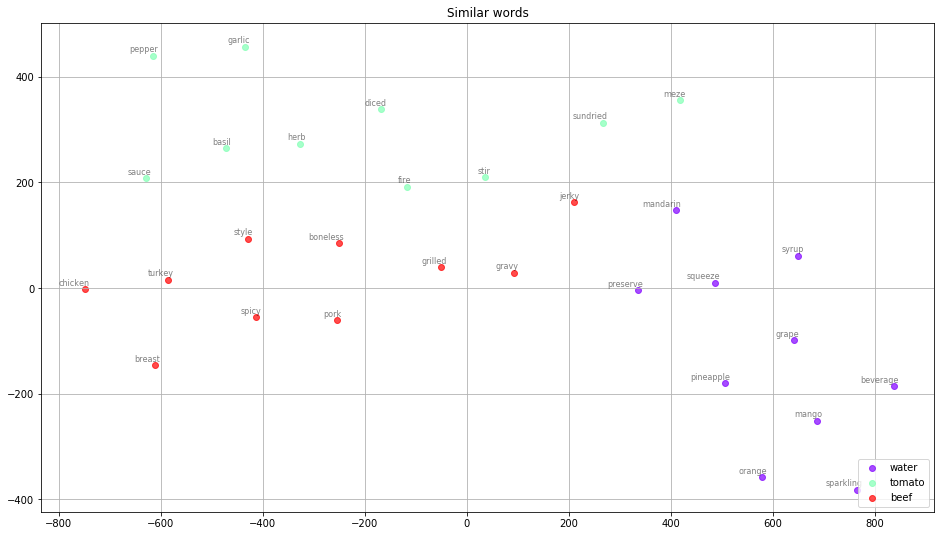

In [245]:
keys = ['water','tomato', 'beef']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2vec_model.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2vec_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

The results looks fine as well

## Making recommendations of Recipes based on the different products in the basket

In [246]:
#Creating function to recode combination of words from vocabulary to vectors

def comb2vectors(prod_word, data):
    doc_w2vec=dict()
    
    for row in data.iterrows():
        doc_vector=list()
        for item in row[1]['Value']:
            doc_vector.append(prod_word[item])
        doc_w2vec[row[1]['Key']]=np.average(doc_vector, axis=0)
    
    return doc_w2vec

In [429]:
products_for_recipe= df_fin.iloc[37979:,].rename(index=str, columns={'id': 'Key', 'products_mod_fin': 'Value'})
products_for_recipe.head()

Key                 products  id_new                  products_mod  \
37987    0        Oscar Mayer Bacon   37987         [oscar, mayer, bacon]   
37988    1             cream cheese   37988               [cream, cheese]   
37989    2     braggs liquid aminos   37989      [braggs, liquid, aminos]   
37990    3            sweet gherkin   37990              [sweet, gherkin]   
37991    4  store-bought pound cake   37991  [store, bought, pound, cake]   

             products_mod_stopwords      products_mod_special  \
37987         [oscar, mayer, bacon]     [oscar, mayer, bacon]   
37988               [cream, cheese]           [cream, cheese]   
37989      [braggs, liquid, aminos]  [braggs, liquid, aminos]   
37990              [sweet, gherkin]          [sweet, gherkin]   
37991  [store, bought, pound, cake]     [store, bought, cake]   

               products_lemma           wordcloud                   Value  \
37987   [oscar, mayer, bacon]   oscar,mayer,bacon   [oscar, mayer, bacon]   
37988         [cream, cheese]        cream,cheese         [cream, cheese]   
37989  [bragg, liquid, amino]  bragg,liquid,amino  [bragg, liquid, amino]   
37990        [sweet, gherkin]       sweet,gherkin        [sweet, gherkin]   
37991   [store, bought, cake]   store,bought,cake   [store, bought, cake]   

       length                                            vectors  set  
37987       3  (0.08658123, -0.03147683, -0.096228205, 0.1385...    2  
37988       2  (0.033689275, 0.076493755, 0.10033591, 0.52292...    2  
37989       3  (0.055887323, -0.054886255, 0.08158729, 0.1462...    2  
37990       2  (-0.020044614, -0.084565304, -0.016773267, 0.3...    2  
37991       3  (-0.017153295, -0.024530051, 0.0787505, 0.1664...    2

In [430]:
len(products_for_recipe)

6398

In [431]:
product_recipe_vectors=comb2vectors(prod_word, products_for_recipe)
len(product_recipe_vectors)

6398

In [432]:
#We also need to replace keys by values in the initial recipes dataset to obtain further the recipes vectors
recipes['ingredients_id'] = recipes['ingredients'].apply(lambda x: [d.get(i) for i in x])
recipes.head()

id                                        ingredients  length  \
0  10259  [romaine lettuce, black olives, grape tomatoes...       9   
1  25693  [plain flour, ground pepper, salt, tomatoes, g...      11   
2  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...      12   
3  22213                [water, vegetable oil, wheat, salt]       4   
4   6602  [plain flour, sugar, butter, eggs, fresh ginge...      12   

                                      ingredients_id  \
0  [4398, 246, 1326, 6193, 2703, 5065, 756, 31, 1...   
1  [6161, 669, 284, 2355, 1582, 872, 1872, 2557, ...   
2  [1872, 2703, 284, 2144, 6366, 1481, 2553, 4040...   
3                            [2377, 2881, 5061, 284]   
4  [6161, 4782, 4243, 1872, 1730, 284, 2065, 1936...   

                                                 new  
0  [4398, 246, 1326, 6193, 2703, 5065, 756, 31, 1...  
1  [6161, 669, 284, 2355, 1582, 872, 1872, 2557, ...  
2  [1872, 2703, 284, 2144, 6366, 1481, 2553, 4040...  
3                            [2377, 2881, 5061, 284]  
4  [6161, 4782, 4243, 1872, 1730, 284, 2065, 1936...

In [433]:
#Before we will average the vectors we had to exclude ingredients ids, which were not participated in word2vec
exclude_ing=[1396, 1736, 2430, 3275, 4491, 4803]
recipes['new']=recipes.ingredients_id.apply(lambda x: [i for i in x if i not in exclude_ing])

In [434]:
recipe_table=recipes.rename (index=str, columns={'id': 'Key', 'new': 'Value'})
recipe_table.head()

Key                                        ingredients  length  \
0  10259  [romaine lettuce, black olives, grape tomatoes...       9   
1  25693  [plain flour, ground pepper, salt, tomatoes, g...      11   
2  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...      12   
3  22213                [water, vegetable oil, wheat, salt]       4   
4   6602  [plain flour, sugar, butter, eggs, fresh ginge...      12   

                                      ingredients_id  \
0  [4398, 246, 1326, 6193, 2703, 5065, 756, 31, 1...   
1  [6161, 669, 284, 2355, 1582, 872, 1872, 2557, ...   
2  [1872, 2703, 284, 2144, 6366, 1481, 2553, 4040...   
3                            [2377, 2881, 5061, 284]   
4  [6161, 4782, 4243, 1872, 1730, 284, 2065, 1936...   

                                               Value  
0  [4398, 246, 1326, 6193, 2703, 5065, 756, 31, 1...  
1  [6161, 669, 284, 2355, 1582, 872, 1872, 2557, ...  
2  [1872, 2703, 284, 2144, 6366, 1481, 2553, 4040...  
3                            [2377, 2881, 5061, 284]  
4  [6161, 4782, 4243, 1872, 1730, 284, 2065, 1936...

In [435]:
len(product_recipe_vectors)

6398

In [436]:
#Creating vectors for recipes
recipe_vectors=comb2vectors(product_recipe_vectors, recipe_table)
recipe_vectors

{10259: array([ 0.30156672, -0.30316767, -0.16824129,  0.4111756 ,  0.6617147 ,
         0.05851538,  0.14686565,  0.2769829 , -0.5977384 , -0.3111936 ,
        -0.38021186,  0.210311  , -0.05738501,  0.00467735, -0.1286482 ,
         0.3935778 , -0.83090407,  0.23023775,  0.2539276 , -0.20253828,
        -0.08346644,  0.45163763, -0.7082069 , -0.10569492,  0.10398562,
        -0.10989823,  0.4822329 ,  0.14237815,  0.12443581,  0.44452804,
         0.05389969,  0.25475362,  0.46214983,  0.06931475,  0.04474322,
        -0.251379  , -0.30150402, -0.25923854,  0.08034607,  0.06293386,
        -0.17191358,  0.15559079,  0.20538148, -0.6493361 , -0.2178758 ,
        -0.3490218 ,  0.439708  , -0.15831375, -0.0247841 , -0.2826838 ,
         0.05585969, -0.18523708,  0.31886572,  0.2809348 ,  0.47380596,
         0.23725623, -0.26044446,  0.18457301,  0.38322526,  0.11972099,
        -0.84836656,  0.2531379 ,  0.16779937,  0.2563338 ,  0.15230447,
        -0.14147863,  0.3660967 ,  0.0172499

In [437]:
# Save vector values in list form to the dataframe. 
recipe_table['vectors']=recipe_vectors.values()
recipe_table.head()

Key                                        ingredients  length  \
0  10259  [romaine lettuce, black olives, grape tomatoes...       9   
1  25693  [plain flour, ground pepper, salt, tomatoes, g...      11   
2  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...      12   
3  22213                [water, vegetable oil, wheat, salt]       4   
4   6602  [plain flour, sugar, butter, eggs, fresh ginge...      12   

                                      ingredients_id  \
0  [4398, 246, 1326, 6193, 2703, 5065, 756, 31, 1...   
1  [6161, 669, 284, 2355, 1582, 872, 1872, 2557, ...   
2  [1872, 2703, 284, 2144, 6366, 1481, 2553, 4040...   
3                            [2377, 2881, 5061, 284]   
4  [6161, 4782, 4243, 1872, 1730, 284, 2065, 1936...   

                                               Value  \
0  [4398, 246, 1326, 6193, 2703, 5065, 756, 31, 1...   
1  [6161, 669, 284, 2355, 1582, 872, 1872, 2557, ...   
2  [1872, 2703, 284, 2144, 6366, 1481, 2553, 4040...   
3                            [2377, 2881, 5061, 284]   
4  [6161, 4782, 4243, 1872, 1730, 284, 2065, 1936...   

                                             vectors  
0  (0.30156672, -0.30316767, -0.16824129, 0.41117...  
1  (0.15025415, -0.26669055, -0.09400893, 0.40947...  
2  (0.14897588, -0.1807121, -0.0469176, 0.3594202...  
3  (0.14793995, -0.24853681, 0.0037331097, 0.4042...  
4  (-0.08216537, -0.09927201, 0.16756584, 0.34244...

Now we will use annoy to check for smilarity among recipes dataser and  output the recommendations. We will set-up Angular distance and number of trees equals to 10 (both showed better results than the rest measures during individual assignment)

In [438]:
from annoy import AnnoyIndex
import random

f = 100

ang = AnnoyIndex(f, metric='angular') 

for index, row in recipe_table.iterrows():
    ang.add_item(row['Key'], row['vectors'])

ang.build(10)

True

In [439]:
#Now we will also creating a function to get vectors for each word in the basket and then average them

def prodlist2vectors(prod_word, prodlist):
    prodlist_vector=list()
    for item in prodlist:
        prodlist_vector.append(prod_word[item])
    return np.average(prodlist_vector, axis=0)

In [440]:
#basket_products=['salt', 'beef', 'pepper', 'wine']
#basket_products=['pasta', 'cheese']
basket_products=['rice', 'sauce', 'spicy', 'chicken']

In [441]:
basket_vector=prodlist2vectors(prod_word, basket_products)
display(basket_products)
display(basket_vector)

['rice', 'sauce', 'spicy', 'chicken']

array([ 3.20952535e-01, -2.67297566e-01, -1.21166945e-01,  4.85961109e-01,
        7.75382757e-01,  1.02445461e-01,  1.55536924e-02,  4.60539371e-01,
       -1.00064480e+00, -2.50462115e-01, -3.47322583e-01,  2.28881896e-01,
       -1.69326365e-01,  1.59485966e-01, -2.28019953e-01,  6.93886220e-01,
       -1.00170088e+00,  8.02175999e-02,  5.13863444e-01, -1.93399489e-01,
       -3.90151367e-02,  5.19889057e-01, -7.77580261e-01, -9.38786790e-02,
        2.26322845e-01, -3.12837780e-01,  6.43564045e-01, -5.33983856e-02,
        1.22845173e-03,  2.13791460e-01,  1.33915991e-03,  2.23787025e-01,
        6.10218585e-01, -2.61515789e-02,  1.17206231e-01, -7.34734058e-01,
       -3.80365223e-01, -3.64280701e-01,  1.22912943e-01, -1.58414971e-02,
       -4.82281148e-02,  1.33143235e-02, -1.17333189e-01, -7.52841234e-01,
       -8.70778784e-02, -1.59110025e-01,  8.60522151e-01, -2.12599710e-01,
       -2.31544688e-01, -5.62554359e-01,  1.09120645e-03, -1.69806793e-01,
        4.09594536e-01,  

In [442]:
#Getting the similar recipes ids and distance to them
similar_recipes=ang.get_nns_by_vector(basket_vector, 5, search_k=-1, include_distances=True)
similar_recipes

([21841, 8373, 46557, 3246, 4515],
 [0.1293201595544815,
  0.13467352092266083,
  0.1372062861919403,
  0.14992709457874298,
  0.1502387672662735])

In [448]:
#Checking the quality of recommendations
similar_recipes=ang.get_nns_by_vector(basket_vector, 5, search_k=-1, include_distances=False)

for i in similar_recipes:
    print(i, list(recipe_table[recipe_table.Key==i]['ingredients']))

21841 [['cooked rice', 'skinless chicken breasts']]
8373 [['broccoli', 'Italian herbs', 'fresh parsley', 'polish sausage', 'rice', 'stewed tomatoes', 'cooked chicken breasts']]
46557 [['boneless chicken breast', 'eggs', 'scallions', 'dipping sauces', 'sushi rice', 'onions']]
3246 [['cajun seasoning', 'hot sauce', 'chicken wings']]
4515 [['diced onions', 'smoked sausage', 'shrimp', 'crushed tomatoes', 'rice', 'chicken broth', 'chopped celery', 'chicken', 'cajun seasoning', 'carrots']]


Our toy recommender works pretty well

## Making recommendations of Recipes for the real baskets (from Instacart dataset)

Let's try more complex stuff - output the recommendations for real order baskets

### Creating Vectors for baskets 

In [552]:
products_for_intacart= df_fin.iloc[:37979,].rename(index=str, columns={'id': 'Key', 'products_mod_fin': 'Value'})
products_for_intacart.tail()

Key                                           products  id_new  \
37982  22827                         Organic Black Mission Figs   37982   
37983  28655                         Crystallized Ginger Chunks   37983   
37984  30365                                    Vegetable Chips   37984   
37985  38007                     Naturally Sweet Plantain Chips   37985   
37986  48778  Fit Super A Juice, Cold Pressed, Carrot/Apple/...   37986   

                                            products_mod  \
37982                    [organic, black, mission, figs]   
37983                     [crystallized, ginger, chunks]   
37984                                 [vegetable, chips]   
37985                [naturally, sweet, plantain, chips]   
37986  [fit, super, a, juice, cold, pressed, carrot, ...   

                                  products_mod_stopwords  \
37982                    [organic, black, mission, figs]   
37983                     [crystallized, ginger, chunks]   
37984                                 [vegetable, chips]   
37985                [naturally, sweet, plantain, chips]   
37986  [fit, super, juice, cold, pressed, carrot, app...   

                                    products_mod_special  \
37982                    [organic, black, mission, figs]   
37983                     [crystallized, ginger, chunks]   
37984                                 [vegetable, chips]   
37985                [naturally, sweet, plantain, chips]   
37986  [fit, super, juice, cold, pressed, carrot, app...   

                                          products_lemma  \
37982                     [organic, black, mission, fig]   
37983                      [crystallized, ginger, chunk]   
37984                                  [vegetable, chip]   
37985                 [naturally, sweet, plantain, chip]   
37986  [fit, super, juice, cold, pressed, carrot, app...   

                                              wordcloud  \
37982                         organic,black,mission,fig   
37983                         crystallized,ginger,chunk   
37984                                    vegetable,chip   
37985                     naturally,sweet,plantain,chip   
37986  fit,super,juice,cold,pressed,carrot,apple,ginger   

                                                   Value  length  \
37982                              [black, mission, fig]       3   
37983                      [crystallized, ginger, chunk]       3   
37984                                  [vegetable, chip]       2   
37985                 [naturally, sweet, plantain, chip]       4   
37986  [fit, super, juice, cold, pressed, carrot, app...       8   

                                                 vectors  set  
37982  (0.06974041, -0.19387819, -0.021844072, 0.2547...    1  
37983  (0.1594919, -0.09329313, 0.17827679, 0.2551541...    1  
37984  (0.15572125, -0.2281132, 0.12872905, 0.5755111...    1  
37985  (-0.029913493, -0.07265581, 0.027666064, 0.406...    1  
37986  (0.23180808, -0.20808099, 0.22475159, 0.388980...    1

In [553]:
len(products_for_intacart)

37979

In [554]:
product_baskets_vectors=comb2vectors(prod_word, products_for_intacart)
len(product_baskets_vectors)

37979

In [555]:
#Dropping unnecessary columns
baskets=df_baskets.drop(['product_id','length'], axis=1)
baskets.head()

new  length_new
order_id                                                               
25        [9755, 31487, 37510, 14576, 22105, 1934, 6383,...          13
40                             [10070, 42450, 33198, 34866]           4
43                      [20915, 21949, 37867, 21553, 34005]           5
51        [30274, 3594, 14994, 45433, 44514, 32624, 2119...           8
83        [13176, 1087, 35503, 4945, 40587, 11574, 37935...          14

In [556]:
#Before we will average the vectors we had to exclude ingredients ids, which were not participated in word2vec
exclude_prd=[530, 3186, 4156, 28921, 43552, 18561, 25334, 38324]
baskets['new_fin']=baskets.new.apply(lambda x: [i for i in x if i not in exclude_prd])
baskets.head()

new  length_new  \
order_id                                                                  
25        [9755, 31487, 37510, 14576, 22105, 1934, 6383,...          13   
40                             [10070, 42450, 33198, 34866]           4   
43                      [20915, 21949, 37867, 21553, 34005]           5   
51        [30274, 3594, 14994, 45433, 44514, 32624, 2119...           8   
83        [13176, 1087, 35503, 4945, 40587, 11574, 37935...          14   

                                                    new_fin  
order_id                                                     
25        [9755, 31487, 37510, 14576, 22105, 1934, 6383,...  
40                             [10070, 42450, 33198, 34866]  
43                      [20915, 21949, 37867, 21553, 34005]  
51        [30274, 3594, 14994, 45433, 44514, 32624, 2119...  
83        [13176, 1087, 35503, 4945, 40587, 11574, 37935...

In [557]:
basket_table=baskets.reset_index()
basket_table=basket_table.rename(index=str, columns={'order_id': 'Key', 'new_fin': 'Value'})
basket_table.head()

Key                                                new  length_new  \
0   25  [9755, 31487, 37510, 14576, 22105, 1934, 6383,...          13   
1   40                       [10070, 42450, 33198, 34866]           4   
2   43                [20915, 21949, 37867, 21553, 34005]           5   
3   51  [30274, 3594, 14994, 45433, 44514, 32624, 2119...           8   
4   83  [13176, 1087, 35503, 4945, 40587, 11574, 37935...          14   

                                               Value  
0  [9755, 31487, 37510, 14576, 22105, 1934, 6383,...  
1                       [10070, 42450, 33198, 34866]  
2                [20915, 21949, 37867, 21553, 34005]  
3  [30274, 3594, 14994, 45433, 44514, 32624, 2119...  
4  [13176, 1087, 35503, 4945, 40587, 11574, 37935...

In [471]:
len(basket_table)

204109

In [558]:
# Remove empty baskets
basket_table = basket_table[basket_table.astype(str)['Value'] != '[]']
len(basket_table)

204108

In [559]:
#Creating vectors for baskets
baskets_vectors=comb2vectors(product_baskets_vectors, basket_table)
baskets_vectors

{25: array([ 0.20752516, -0.07550008, -0.13744959,  0.29638883,  0.70258904,
        -0.11982865,  0.13662384,  0.36702102, -0.56287014, -0.25713995,
        -0.28443468,  0.17511725, -0.04750123,  0.13547194, -0.27059   ,
         0.44281867, -0.74040973,  0.1988411 ,  0.2833043 , -0.06050101,
        -0.09299341,  0.4813817 , -0.72905946, -0.14039174,  0.10109068,
        -0.1990687 ,  0.3731066 ,  0.05074447,  0.01376651,  0.24061874,
         0.03560905,  0.10146867,  0.37737134,  0.01624033, -0.04671869,
        -0.2980497 , -0.42681396, -0.0149783 ,  0.05360031,  0.02353455,
        -0.09659992, -0.01045584,  0.12948862, -0.6187713 , -0.1236067 ,
        -0.5373722 ,  0.6438398 , -0.13590322, -0.19961636, -0.32548115,
        -0.04359264, -0.37522036,  0.15913309,  0.37070483,  0.5231705 ,
        -0.13748997, -0.26908472,  0.2416794 ,  0.14048178,  0.20333025,
        -0.52728266,  0.04670976,  0.35349464,  0.13658836,  0.3461329 ,
        -0.02204128,  0.21699251, -0.09018828, 

In [560]:
# Save vector values in list form to the dataframe. 
basket_table['vectors']=baskets_vectors.values()
basket_table.head()

Key                                                new  length_new  \
0   25  [9755, 31487, 37510, 14576, 22105, 1934, 6383,...          13   
1   40                       [10070, 42450, 33198, 34866]           4   
2   43                [20915, 21949, 37867, 21553, 34005]           5   
3   51  [30274, 3594, 14994, 45433, 44514, 32624, 2119...           8   
4   83  [13176, 1087, 35503, 4945, 40587, 11574, 37935...          14   

                                               Value  \
0  [9755, 31487, 37510, 14576, 22105, 1934, 6383,...   
1                       [10070, 42450, 33198, 34866]   
2                [20915, 21949, 37867, 21553, 34005]   
3  [30274, 3594, 14994, 45433, 44514, 32624, 2119...   
4  [13176, 1087, 35503, 4945, 40587, 11574, 37935...   

                                             vectors  
0  (0.20752516, -0.07550008, -0.13744959, 0.29638...  
1  (0.19337952, -0.18453862, 0.21710163, 0.392355...  
2  (0.18855274, -0.110186264, -0.006886433, 0.327...  
3  (0.15002532, -0.082276955, 0.012572631, 0.2044...  
4  (0.13283354, -0.1280941, 0.07825404, 0.3783907...

In [561]:
#For faster computations we will make sub-sample of baskets
annoy_bask=basket_table.sample(frac=0.005)
annoy_bask.shape

(1021, 5)

In [562]:
#We will create a function to return keys (product names)
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

#Replacing id with product names
annoy_bask['ingredients_names'] = annoy_bask['new'].apply(lambda x: [get_key(dic_instacart, i) for i in x])
annoy_bask.head()

Key                                        new  length_new  \
73639   1243063         [5258, 33000, 31343, 15200, 32079]           5   
32357    549806                [9076, 13176, 37646, 32864]           4   
48863    827040         [11494, 9290, 35221, 36766, 44310]           5   
178319  2991669  [29127, 36809, 24179, 15604, 6347, 40545]           6   
51145    864079  [21144, 40878, 13925, 37092, 2120, 29312]           6   

                                            Value  \
73639          [5258, 33000, 31343, 15200, 32079]   
32357                 [9076, 13176, 37646, 32864]   
48863          [11494, 9290, 35221, 36766, 44310]   
178319  [29127, 36809, 24179, 15604, 6347, 40545]   
51145   [21144, 40878, 13925, 37092, 2120, 29312]   

                                                  vectors  \
73639   (0.22458479, -0.18747398, -0.0253896, 0.361270...   
32357   (0.10453917, -0.14817786, 0.18221076, 0.324701...   
48863   (0.09799411, -0.0509981, 0.13545902, 0.3857424...   
178319  (0.070017256, -0.19312483, 0.27144554, 0.35535...   
51145   (0.11510753, -0.08967686, 0.07976366, 0.345832...   

                                        ingredients_names  
73639   [Sparkling Water, Pure Irish Butter, Shredded ...  
32357   [Blueberries, Bag of Organic Bananas, Organic ...  
48863   [Cookie Dough Ice Cream Chocolate Chip, Countr...  
178319  [Dairy Free Unsweetened Coconut Milk, Organic ...  
51145   [Grab & Go Classic Hummus With Pretzel Crisps,...

In [596]:
annoy_bask.head(20)

Key                                                new  \
73639   1243063                 [5258, 33000, 31343, 15200, 32079]   
32357    549806                        [9076, 13176, 37646, 32864]   
48863    827040                 [11494, 9290, 35221, 36766, 44310]   
178319  2991669          [29127, 36809, 24179, 15604, 6347, 40545]   
51145    864079          [21144, 40878, 13925, 37092, 2120, 29312]   
131355  2202984                [34050, 32429, 15290, 21616, 21019]   
35317    600721                                            [41787]   
6047     101704  [38490, 35121, 37646, 8174, 5161, 17791, 21137...   
22674    384283  [18023, 43154, 12427, 16714, 6760, 31651, 4652...   
186067  3118208    [25544, 1338, 10749, 5450, 21938, 26209, 49683]   
153049  2567990  [22882, 32691, 33357, 12276, 40002, 25837, 849...   
203030  3403262                                            [30489]   
78629   1325289  [44142, 47766, 26209, 16083, 44987, 32403, 248...   
198198  3323351            [26166, 3040, 5248, 17710, 7571, 21125]   
131450  2204450  [17355, 24489, 27966, 9390, 26604, 21903, 2113...   
135503  2272957  [24852, 43086, 47766, 36070, 27845, 2480, 3101...   
162968  2734782  [21616, 4799, 49683, 35503, 4945, 34993, 17758...   
176228  2957080  [45066, 21137, 8174, 18171, 30252, 9839, 30489...   
22675    384294                [47766, 41120, 15318, 22472, 47141]   
133610  2240852  [42625, 28204, 18531, 40858, 39928, 37687, 349...   

        length_new                                              Value  \
73639            5                 [5258, 33000, 31343, 15200, 32079]   
32357            4                        [9076, 13176, 37646, 32864]   
48863            5                 [11494, 9290, 35221, 36766, 44310]   
178319           6          [29127, 36809, 24179, 15604, 6347, 40545]   
51145            6          [21144, 40878, 13925, 37092, 2120, 29312]   
131355           5                [34050, 32429, 15290, 21616, 21019]   
35317            1                                            [41787]   
6047            11  [38490, 35121, 37646, 8174, 5161, 17791, 21137...   
22674           12  [18023, 43154, 12427, 16714, 6760, 31651, 4652...   
186067           7    [25544, 1338, 10749, 5450, 21938, 26209, 49683]   
153049          16  [22882, 32691, 33357, 12276, 40002, 25837, 849...   
203030           1                                            [30489]   
78629           21  [44142, 47766, 26209, 16083, 44987, 32403, 248...   
198198           6            [26166, 3040, 5248, 17710, 7571, 21125]   
131450          10  [17355, 24489, 27966, 9390, 26604, 21903, 2113...   
135503          25  [24852, 43086, 47766, 36070, 27845, 2480, 3101...   
162968          17  [21616, 4799, 49683, 35503, 4945, 34993, 17758...   
176228          15  [45066, 21137, 8174, 18171, 30252, 9839, 30489...   
22675            5                [47766, 41120, 15318, 22472, 47141]   
133610          11  [42625, 28204, 18531, 40858, 39928, 37687, 349...   

                                                  vectors  \
73639   (0.22458479, -0.18747398, -0.0253896, 0.361270...   
32357   (0.10453917, -0.14817786, 0.18221076, 0.324701...   
48863   (0.09799411, -0.0509981, 0.13545902, 0.3857424...   
178319  (0.070017256, -0.19312483, 0.27144554, 0.35535...   
51145   (0.11510753, -0.08967686, 0.07976366, 0.345832...   
131355  (0.35838786, -0.33642113, 0.046298057, 0.46608...   
35317   (0.13802022, -0.10436697, 0.086328566, 0.22179...   
6047    (0.11987205, -0.112502806, 0.3090566, 0.365420...   
22674   (0.115251265, -0.11901245, 0.15696281, 0.34686...   
186067  (0.18858573, -0.25514722, -0.10358946, 0.37479...   
153049  (0.0332342, -0.11152099, 0.25435963, 0.3744554...   
203030  (0.21698552, -0.18583539, -0.048951093, 0.3477...   
78629   (0.114319235, -0.14868648, 0.09274402, 0.35534...   
198198  (0.10478959, -0.085757606, 0.07937401, 0.32549...   
131450  (0.0906104, -0.13971451, 0.21710339, 0.3426470...   
135503  (0.07591102, -0.1253772

Now using the vectors embeddings (for each basket and recipe) we will get the similarity by one to another by using annoy function 

In [566]:
annoy_bask['Key']=annoy_bask['Key'].astype(int)

In [609]:
#We can choose any basket number from the dataset (column basket_number)
number=1243063

In [610]:
#Printing products in the basket
for i in annoy_bask[annoy_bask.Key==number]['ingredients_names']:
    print(i)

['Sparkling Water', 'Pure Irish Butter', 'Shredded Mild Cheddar Cheese', 'Organic Green Beans', 'Shredded Parmigiano Reggiano']


Now we should output the recipes by iterating through the baskets and outputing closer recipe

In [611]:
#Getting recipes ids and distances
recipes_recommendation = ang.get_nns_by_vector(baskets_vectors[number], 3, search_k=-1, include_distances=True)
recipes_recommendation 

([3447, 19232, 45389],
 [0.10827312618494034, 0.11013271659612656, 0.11331791430711746])

In [613]:
#Checking the quality of recommendations
recipes_recommendation=ang.get_nns_by_vector(baskets_vectors[number], 3, search_k=-1, include_distances=False)

for i in recipes_recommendation:
    print(i, list(recipe_table[recipe_table.Key==i]['ingredients']))

3447 [['ragu', 'curds', 'gremolata', 'gnocchi']]
19232 [['lime wedges', 'cantaloupe', 'mint leaves', 'manchego cheese']]
45389 [['smoked ham', 'juice', 'red pepper flakes', 'sliced green onions', 'pineapple chunks', 'cream cheese', 'flour tortillas', 'shredded mozzarella cheese']]


In general, it looks fine